# Predicción ganador UEFA Champions League 2023/24 con modelo Random Forest
Vamos a entrenar un modelo Random Forest para predecir el ganador de la UEFA Champions League 2023/24. 

Procedimiento:
1. **Preprocesamiento de los datos**
    - Crear variable categórica objetivo (***Is_Winner***)
    - Análisis exploratorio de los datos
    - Ajustar variables según su naturaleza (codificación, estandarización)

2. **Entrenamiento del modelo**
    - Dividir el conjunto de datos en entrenamiento y prueba
    - Entrenar el modelo Random Forest usando MLflow
    - Evaluar el modelo

3. **Análisis de resultados**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_clasif = pd.read_csv('data/UCL_CF_comp_2004_2023.csv')

## 1.- Preprocesar datos

### Crear variable objetivo
Creamos la variale categórica 'Is_Winner', que será nuestra variable objetivo en el entrenamiento del modelo. Esta variable toma el valor de 1 si el equipo ha ganado la UCL y 0 si no.

In [6]:
ganadores = df_clasif[(df_clasif['Rk']==1)][['Squad', 'Year']]
ganadores = ganadores.rename(columns={'Squad': 'Winner'})

df_clasif_compl = df_clasif.merge(ganadores, how='left', left_on=['Squad', 'Year'], right_on=['Winner', 'Year'])

# variable binaria que indica si el equipo es ganador o no
df_clasif_compl['Is_Winner'] = df_clasif_compl['Winner'].notnull().astype(int)

df_clasif_compl.drop(columns='Winner', inplace=True)
df_clasif_compl.set_index('Team_ID', inplace=True)

In [7]:
df_clasif_compl

,Rk,Stage,Squad,MP,W,D,L,GF,GA,GD,Pts,Year,Is_Winner
Team_ID,,,,,,,,,,,,,
22,1,W,pt Porto,13.0,7.0,6.0,1.0,20.0,12.0,8.0,27.0,2004,1
9,2,F,fr Monaco,13.0,6.0,4.0,4.0,27.0,19.0,8.0,22.0,2004,0
25,3,SF,eng Chelsea,14.0,8.0,4.0,2.0,21.0,10.0,11.0,28.0,2004,0
10,4,SF,es La Coruña,14.0,7.0,3.0,4.0,20.0,17.0,3.0,24.0,2004,0
21,5,QF,es Real Madrid,10.0,6.0,3.0,1.0,18.0,11.0,7.0,21.0,2004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,28,GR,dk FC Copenhagen,6.0,0.0,3.0,3.0,1.0,12.0,-11.0,3.0,2023,0
71,29,GR,il Maccabi Haifa,6.0,1.0,0.0,5.0,7.0,21.0,-14.0,3.0,2023,0
3,30,GR,sct Celtic,6.0,0.0,2.0,4.0,4.0,15.0,-11.0,2.0,2023,0


In [8]:
# generamos un csv para usarlo posteriormente
df_clasif_compl.to_csv('data/UCL_CF_preprocesado.csv', index=True)

### Análisis exploratorio de datos

VARIABLES NUMÉRICAS:
- **W** (won): Número de partidos ganados
- **D** (drawn): Número de partidos empatados
- **L** (lost): Número de partidos perdidos
- **GD** (goal difference): Diferencia de goles
- **Pts** (points): Puntos obtenidos en la fase de grupos

VARIABLES CATEGÓRICAS:
- **Rk** (ranking): Ranking en la clasificación de fase de grupos
- **Squad**: Equipo
- **Is_Winner**: variable binaria de si ha ganado la champions en esa temporada o no


Las variables **MP** (matches played), **Group** y **'Year'** no  son relevantes para el análisis, por lo que no las usaremos.

In [9]:
cols = ['Rk', 'Squad', 'W', 'D', 'L', 'GD', 'Pts', 'Is_Winner']
df = df_clasif_compl[cols].copy()
df.head()

,Rk,Squad,W,D,L,GD,Pts,Is_Winner
Team_ID,,,,,,,,
22,1,pt Porto,7.0,6.0,1.0,8.0,27.0,1
9,2,fr Monaco,6.0,4.0,4.0,8.0,22.0,0
25,3,eng Chelsea,8.0,4.0,2.0,11.0,28.0,0
10,4,es La Coruña,7.0,3.0,4.0,3.0,24.0,0
21,5,es Real Madrid,6.0,3.0,1.0,7.0,21.0,0


In [10]:
var_num = ['W', 'D', 'L', 'GD', 'Pts']
var_cat = ['Rk', 'Squad', 'Is_Winner']

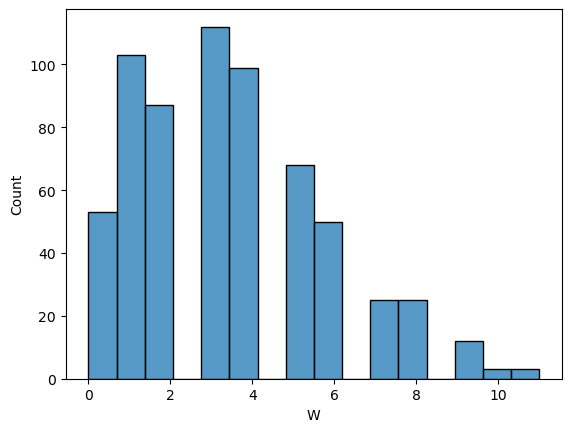

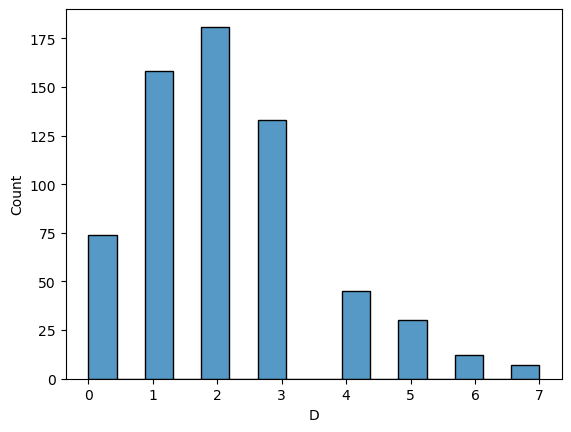

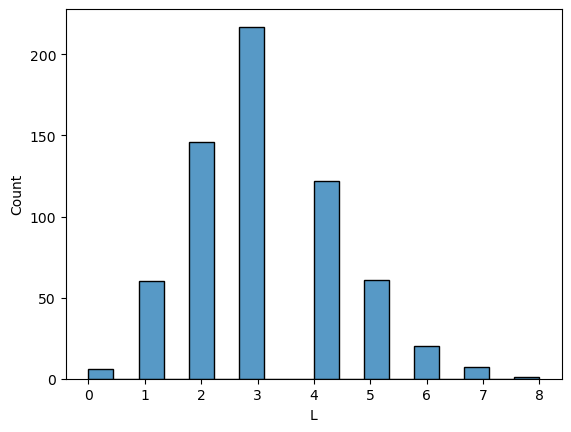

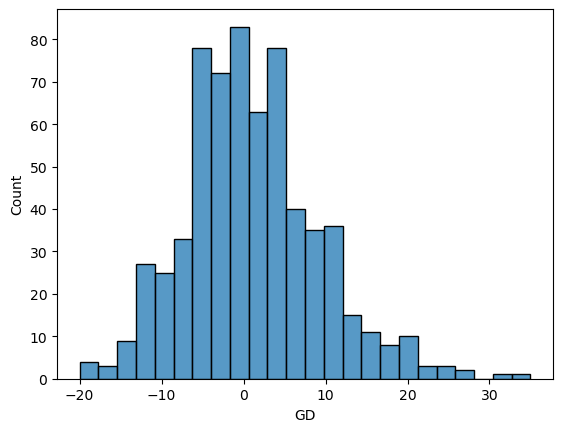

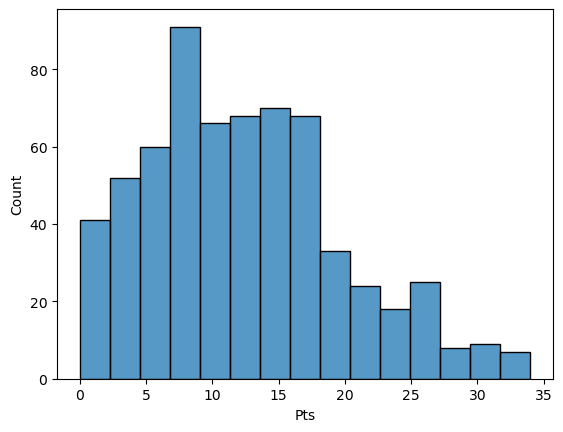

In [11]:
# visualización variables numéricas
for v in var_num:
    sns.histplot(df[v])
    plt.show()

### Modificar variables

CODIFICAR VARIABLES CATEGÓRICAS:  
Las variables **'Rk'** y **'Is_Winner'** ya están codificadas como categóricas. 
Para la variable **'Squad'**, como los equipos se repiten a lo largo de las distintas temporadas, vamos a codificarla como categórica.

In [15]:
# Codificar la variable 'Squad' usando codificación one-hot
df_categ = pd.get_dummies(df[var_cat], columns=['Squad'], prefix='Team').astype(int).set_index(df.index)

df_categ.head()

,Rk,Is_Winner,Team_at Austria Wien,Team_at RB Salzburg,Team_at Rapid Wien,Team_az Qarabağ FK,Team_be Anderlecht,Team_be Club Brugge,Team_be Genk,Team_be Gent,...,Team_sk Artmedia,Team_sk MŠK Žilina,Team_tr Başakşehir,Team_tr Beşiktaş,Team_tr Bursaspor,Team_tr Fenerbahçe,Team_tr Galatasaray,Team_tr Trabzonspor,Team_ua Dynamo Kyiv,Team_ua Shakhtar
Team_ID,,,,,,,,,,,,,,,,,,,,,
22,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ESTANDARIZAR VARIABLES NUMÉRICAS CONTINUAS  
que están a escalas distintas, para que tengan el mismo peso en el modelo.

In [12]:
from sklearn.preprocessing import StandardScaler

var_num_cont = ['GD', 'Pts']

scaler = StandardScaler()
scaler_charges = scaler.fit(df[var_num_cont])
vect_est = scaler_charges.transform(df[var_num_cont])  # array

# transformar el array en un dataframe
df_estand = pd.DataFrame(vect_est, columns=var_num_cont).set_index(df.index)
df_estand.head()

,GD,Pts
Team_ID,,
22,0.857797,1.985274
9,0.857797,1.304000
25,1.226824,2.121528
10,0.242751,1.576509
21,0.734788,1.167745


In [13]:
# juntar el dataframe con las otras variables numericas
var_num_disc = ['W', 'D', 'L']
df_num = df_estand.join(df[var_num_disc].set_index(df.index))
df_num.head()


,GD,Pts,W,D,L
Team_ID,,,,,
1,-0.126277,0.622727,5.0,2.0,3.0
1,-0.126277,0.622727,6.0,3.0,1.0
1,-0.126277,0.622727,7.0,2.0,1.0
1,-0.126277,0.622727,4.0,3.0,1.0
1,-0.126277,0.622727,3.0,2.0,3.0


In [16]:
# dataframe final
df_1 = df_num.join(df_categ)
df_1.head()

,GD,Pts,W,D,L,Rk,Is_Winner,Team_at Austria Wien,Team_at RB Salzburg,Team_at Rapid Wien,...,Team_sk Artmedia,Team_sk MŠK Žilina,Team_tr Başakşehir,Team_tr Beşiktaş,Team_tr Bursaspor,Team_tr Fenerbahçe,Team_tr Galatasaray,Team_tr Trabzonspor,Team_ua Dynamo Kyiv,Team_ua Shakhtar
Team_ID,,,,,,,,,,,,,,,,,,,,,
1,-0.126277,0.622727,5.0,2.0,3.0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.126277,0.622727,5.0,2.0,3.0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.126277,0.622727,5.0,2.0,3.0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.126277,0.622727,5.0,2.0,3.0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.126277,0.622727,5.0,2.0,3.0,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.- Modelo Random Forest Classifier
Para preedcir la variable categórica objetivo 'Is_Winner'.

In [17]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from tabulate import tabulate

### Dividir train y test

In [19]:
var_indep = df_1.columns.tolist()
var_indep.remove('Is_Winner')  # que va a ser nuestra variable objetivo

X_train, X_test, y_train, y_test = train_test_split(df_1[var_indep], df_1['Is_Winner'], train_size = 0.2, random_state = 42)


### Entrenar modelo Random Forest

In [20]:
modelo_RF = RandomForestClassifier(n_estimators = 3, criterion ='entropy')
modelo_RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=3)

In [21]:
y_predict_RF_1 = modelo_RF.predict(X_test)
y_predict_RF_1

array([1, 0, 0, ..., 1, 0, 0])

### Evaluación modelo

In [22]:
print("------------------------------------")
print("SCORE FOR RANDOM FOREST MODEL")
print("------------------------------------")
print()

print("Train set score (Accuracy) =", modelo_RF.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", modelo_RF.score(X_test, y_test).round(4))
print()
conf_mat = confusion_matrix(y_test, y_predict_RF_1)
print(tabulate(conf_mat,headers = ['Pred N','Pred P'], showindex = ['Real N','Real P'], tablefmt = 'fancy_grid'))
print('TN:', conf_mat[0,0])
print('FP:', conf_mat[0,1])
print('FN:', conf_mat[1,0])
print('TP:', conf_mat[1,1])
print()
print()
print("CLASSIFICATION REPORT")
print("----------------------")
print(classification_report(y_test, y_predict_RF_1))

------------------------------------
SCORE FOR RANDOM FOREST MODEL
------------------------------------

Train set score (Accuracy) = 1.0
Test set score (Accuracy) = 0.9995

╒════════╤══════════╤══════════╕
│        │   Pred N │   Pred P │
╞════════╪══════════╪══════════╡
│ Real N │    64162 │       10 │
├────────┼──────────┼──────────┤
│ Real P │       26 │     4998 │
╘════════╧══════════╧══════════╛
TN: 64162
FP: 10
FN: 26
TP: 4998


CLASSIFICATION REPORT
----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64172
           1       1.00      0.99      1.00      5024

    accuracy                           1.00     69196
   macro avg       1.00      1.00      1.00     69196
weighted avg       1.00      1.00      1.00     69196



## 3.- Análisis resultados

Este modelo, predice bien los True Negatives, ya que teiene muchos datos acerca de los equipos que no han ganado la champions (en cada temporada, de 32 equipos sólo gana 1). Sin embargo, la predicción de True Positives es bastante pobre. Esto es seguramente porque el dataset está muy desequilibrado, hay muchos más datos de equipos que pierden, que de equipos que ganan, lo que supone que el modelo no tiene suficientes datos para aprender a predecir los equipos que ganan la champions.  
  
Como no nos podemos inventar datos sobre equipos que han ganado la champions, ya que no serían fieles a la realidad, y tampoco podemos reducir el número de datos de equipos que no han ganado la champions, ya que perderíamos mucha información, la única solución para esquivar este problema de desequilibrio de datos, sería cambiar el enfoque de la estructuración de los datos.    
  
En lugar de predecir si un equipo ha ganado la UCL o no, vamos a predecir, partido a partido, según los encuentros de las fases finales, si un equipo va a ganar o no. De esta forma, siguiendo la estructura de partidos de la competición, conseguiríamos llegar a predecir el equipo ganador del torneo.

También planteamos, más a medio plazo, ponderar los datos. Dado que tenemos datos históricos separados para fases de grupos y fases finales, sería muy interesante entrenar el modelo dando un peso menor a los partidos de fases de grupos y más peso a los partidos de fases finales, ya que a medida que se avanza en la competición, los equipos son más fuertes y las victoriasa son más significativas.